In [1]:
from dataset import *
from moco_model import MoCo
from train import *
import tqdm


In [2]:
path_stem = '../datasets/NDI_images/Integreted/Observed/'
parameters = {'original_image': [path_stem + '', path_stem + 'normalized_pics', path_stem + 'circle_masked_pics', 
                                 path_stem + 'circle_centrosysmmetric_pics']}
list(itertools.product(*parameters.values()))

[('../datasets/NDI_images/Integreted/Observed/',),
 ('../datasets/NDI_images/Integreted/Observed/normalized_pics',),
 ('../datasets/NDI_images/Integreted/Observed/circle_masked_pics',),
 ('../datasets/NDI_images/Integreted/Observed/circle_centrosysmmetric_pics',)]

In [3]:
path_stem = '../datasets/NDI_images/Integreted/Observed/'

top_k_candidates = (10, 20, 30)
k = 7
temps = 0.7
momentums = 0.99
k_value = 64
parameters = {'original_image': [path_stem + '', path_stem + 'normalized_pics', path_stem + 'circle_masked_pics', 
                                 path_stem + 'circle_centrosysmmetric_pics', path_stem + 'circle_binaryzation_pics']}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))

for parameter in itertools.product(*parameters.values()):

    ### custom part to get parameters
    ORIGINAL_IMAGE = parameter[0]
    ### END
    
    for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
        train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
        model = torchvision.models.resnet50
        model = MoCo(model, dim=512, K=k_value, T=temps, m=momentums, model_type='resnet',
                        weights=ResNet50_Weights.IMAGENET1K_V2, three_channel=True)
        device = torch.device('cuda:0')
        criterion = nn.CrossEntropyLoss().cuda(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        start_time = time.time()
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, criterion, optimizer, 100, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Epoch 1, Train_Loss 3.989612674713135, Val_loss 4.301832675933838
Train_acc_top_10 0.0625	Train_acc_top_20 0.1062	Train_acc_top_30 0.1375	
Val_acc_top_10 0.08	Val_acc_top_20 0.08	Val_acc_top_30 0.08	
Epoch 2, Train_Loss 4.155901288986206, Val_loss 4.295040607452393
Train_acc_top_10 0.05	Train_acc_top_20 0.125	Train_acc_top_30 0.1938	
Val_acc_top_10 0.04	Val_acc_top_20 0.08	Val_acc_top_30 0.12	
Epoch 3, Train_Loss 4.155063152313232, Val_loss 4.253817081451416
Train_acc_top_10 0.0563	Train_acc_top_20 0.125	Train_acc_top_30 0.175	
Val_acc_top_10 0.17	Val_acc_top_20 0.21	Val_acc_top_30 0.29	
Epoch 4, Train_Loss 4.142994737625122, Val_loss 4.244986057281494
Train_acc_top_10 0.0625	Train_acc_top_20 0.125	Train_acc_top_30 0.1625	
Val_acc_top_10 0.08	Val_acc_top_20 0.12	Val_acc_top_30 0.21	
Epoch 5, Train_Loss 4.13055944442749, Val_loss 4.234147548675537
Train_acc_top_10 0.05	Train_acc_top_20 0.1187	Train_acc_top_30 0.1875	
Val_acc_top_10 0.04	Val_acc_top_20 0.08	Val_acc_top_30 0.17	
Epoch 6, 

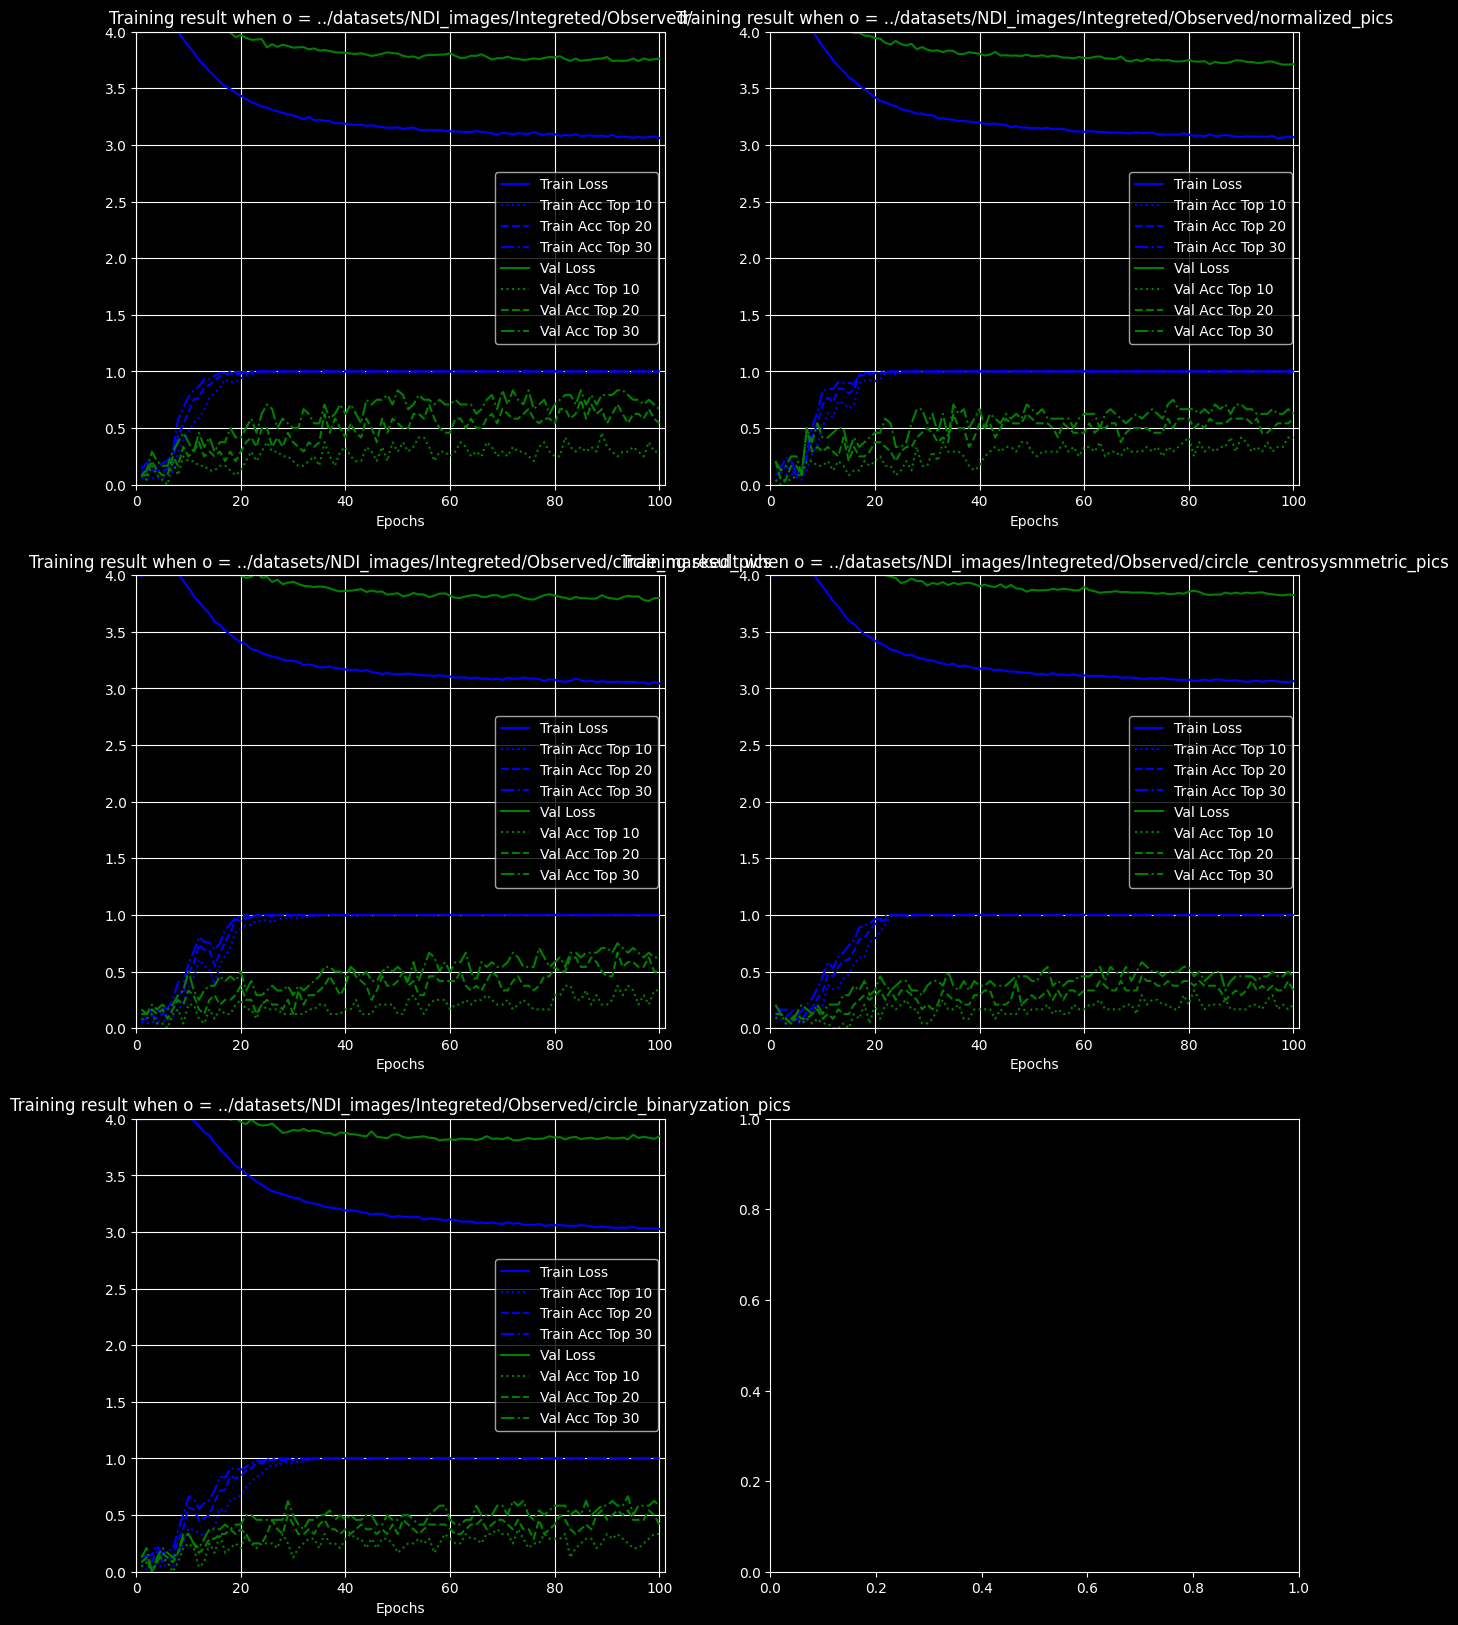

('../datasets/NDI_images/Integreted/Observed/',) 10 mean 0.2958333333333333
('../datasets/NDI_images/Integreted/Observed/',) 10 max 0.4583333333333333
('../datasets/NDI_images/Integreted/Observed/',) 20 mean 0.6125
('../datasets/NDI_images/Integreted/Observed/',) 20 max 0.75
('../datasets/NDI_images/Integreted/Observed/',) 30 mean 0.7583333333333334
('../datasets/NDI_images/Integreted/Observed/',) 30 max 0.8333333333333334
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 10 mean 0.3458333333333333
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 10 max 0.4166666666666667
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 mean 0.5333333333333334
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 20 max 0.625
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 30 mean 0.6416666666666667
('../datasets/NDI_images/Integreted/Observed/normalized_pics',) 30 max 0.75
('../datasets/NDI_images/Integreted/Observed/circle_maske

In [4]:
draw_graph(train_metrics.data, 100, ('origin_path'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')